In [1]:
import numpy as np
#import pandas as pd
import modin.pandas as pd
import ray
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

2026-02-06 13:35:19.700420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 13:35:19.741906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 13:35:20.711724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.random.set_seed(7)
def load_data(filename):
    df = pd.read_csv(filename, parse_dates=['Date'], index_col='Date')
    df = df.sort_index()
    return df

In [ ]:
def explore_data(df, target_col='Adj Close', date_col='Date'):
    df_analysis = df.copy()
    print(f"Shape of dataset: {df_analysis.shape}")
    print(f"Missing vals in each column:\n {df_analysis.isnull().sum()}")
    print(f"Date range: {df_analysis.index.min()} to {df_analysis.index.max()}")

    print(df_analysis.head())
    print(df_analysis.info())
    print(df_analysis.describe())

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle('Stock Price Time Series Analysis', fontsize=16, y=1.02)
    axes[0] = sns.lineplot(data=df_analysis, x=df_analysis.index, y='Adj Close', ax=axes[0])
    axes[0].set_title('Adjusted Close Price Over Time')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Adjusted Close Price')

    price_cols = ['High', 'Low', 'Open', 'Close']
    for col in price_cols:
        axes[1].plot(df_analysis.index, df_analysis[col], alpha=0.6, label=col)
    axes[1].set_title('All Price Features Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)

    rolling_mean = df_analysis['Adj Close'].rolling(window=30).mean()
    rolling_std = df_analysis['Adj Close'].rolling(window=30).std()
    
    axes[2].plot(df_analysis.index, df_analysis['Adj Close'], label='Original', alpha=0.5, linewidth=1)
    axes[2].plot(df_analysis.index, rolling_mean, label='30-day Rolling Mean', color='red', linewidth=2)
    axes[2].fill_between(df_analysis.index, rolling_mean - 2*rolling_std,
    rolling_mean + 2*rolling_std, color='red', alpha=0.1)

    axes[2].set_title(' Adj Closing Price with 30-day Rolling Mean & ±2 Bands')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Adj Close Price')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    correlation_matrix = df_analysis[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    scatter_features = ['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']
    pd.plotting.scatter_matrix(df_analysis[scatter_features], alpha=0.2, diagonal='kde', figsize=(12,12))
    plt.title('Scatter Matrix of Selected Features')
    plt.tight_layout()
    plt.show()

    try:
        adj_close_series = df_analysis['Adj Close'].dropna()
        period = 60
        decomposition = seasonal_decompose(adj_close_series, model='additive', period=period, extrapolate_trend='freq')
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        fig.suptitle(f'Seasonal Decomposition (Period={period} days)', fontsize=14, y=1.02)
        plot_dates = adj_close_series.index[period-1:]
        axes[0].plot(plot_dates, decomposition.observed[period-1:], color='blue', linewidth=1)
        axes[0].set_title('Observed')
        axes[0].grid(True, alpha=0.3)
        axes[1].plot(plot_dates, decomposition.trend[period-1:], color='green', linewidth=1)
        axes[1].set_title('Trend')
        axes[1].grid(True, alpha=0.3)
        axes[2].plot(plot_dates, decomposition.seasonal[period-1:], color='orange', linewidth=1)
        axes[2].set_title('Seasonal')
        axes[2].grid(True, alpha=0.3)
        axes[3].plot(plot_dates, decomposition.resid[period-1:], color='red', linewidth=1)
        axes[3].set_title('Residual')
        axes[3].grid(True, alpha=0.3)
        axes[3].axhline(0, linestyle='--', color='black', linewidth=1)
        plt.tight_layout()
        plt.show()

        seasonal_std = decomposition.seasonal.std()
        trend_std = decomposition.trend.std()
        print(f"Seasonality Std Dev: {seasonal_std:.4f}")
        print(f"Trend Std Dev: {trend_std:.4f}")
        print(f"Seasonality/Trend ratio: {seasonal_std/trend_std:.4f}")
    except Exception as e:
        print(f"Seasonal decomposition warning: {e}")
        print("Trying with different period...")

def init_data_prep(df,features,Seq,target_idx=5):
    data = df[features].values
    scaler = MinMaxScaler(feature_range=(0,1))
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(Seq, len(data_scaled)):
        X.append(data_scaled[i-Seq:i])
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)

    train_size = int(0.8*len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, scaler, features, train_size

def lstm_model(units, Dpr, input_shape):
    optimizer = tf.keras.optimizers.Adam(learning_rate=fixed_testing_parameters['learning_rate'])
    loss = 'mean_squared_error'
    metrics = ['mae','mse']
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape)),BatchNormalization()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape)), LayerNormalization()
    model.add(LSTM(units=units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(Dpr))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=fixed_testing_parameters['patience'], restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=fixed_testing_parameters['min_lr'], verbose=0)
    ]
    return model, callbacks

def model_train_evaluate(epochs, X_train, y_train, X_test, y_test, scaler, features, run_name):
    print(f"Training run: {run_name}")
    print(f"Epochs: {epochs}")
    print("\n")
    print("\n")
    print("\n")

    model, callbacks = lstm_model(
        units=fixed_testing_parameters['units'],
        Dpr = fixed_testing_parameters['Dpr'],
        input_shape = (X_train.shape[1],X_train.shape[2])
    )
    history = model.fit(
        X_train, y_train,
        validation_data = (X_test,y_test),
        epochs=epochs,
        batch_size=fixed_testing_parameters['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    y_pred = model.predict(X_test, verbose=0)

    y_predict_reshape = np.zeros(((len(y_pred)), len(features)))
    y_test_reshape = np.zeros((len(y_test), len(features)))
    y_predict_reshape[:,fixed_testing_parameters['target_idx']] = y_pred.flatten()
    y_test_reshape[:,fixed_testing_parameters['target_idx']] = y_test
    y_predict_invert = scaler.inverse_transform(y_predict_reshape)[:,fixed_testing_parameters['target_idx']]
    y_test_invert = scaler.inverse_transform(y_test_reshape)[:,fixed_testing_parameters['target_idx']]

    mse = mean_squared_error(y_test_invert, y_predict_invert)
    rsme = np.sqrt(mse)
    mae = mean_absolute_error(y_test_invert, y_predict_invert)
    r2 = r2_score(y_test_invert, y_predict_invert)
    final_mse = history.history['val_mse'][-1]
    final_mae = history.history['val_mae'][-1]

    print(f"\nMetrics for {run_name}")
    print(f"Mean squared error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rsme:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"r2 Score: {r2:.4f}")
    print(f"Final Validation MSE: {final_mse}")
    print(f"Final Validation MAE: {final_mae}")

    return {
        'run_name': run_name,
        'epochs': epochs,
        'mse': mse,
        'mae': mae,
        'rsme': rsme,
        'r2': r2,
        'final_mse': final_mse,
        'final_mae': final_mae,
        'history': history.history,
        'model': model,
        'predictions': y_predict_invert,
        'actuals': y_test_invert
    }

def training_visual(results_dict, metric='loss'):
    plt.figure(figsize=(12,8))

    for run_name, result in results_dict.items():
        epochs_trained  = len(result['history'][metric])
        plt.plot(range(1,epochs_trained+1),
                 result['history'][metric],
                 label = f'{run_name} (training)',
                 linewidth = 2)
        plt.plot(range(1,epochs_trained+1),
                 result['history'][f'val_{metric}'],
                 label = f'{run_name} (Validation)',
                 linewidth = 2, linestyle = '--')
    plt.title(f'Validation and Training {metric.upper()} Comparision', fontsize = 16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric.upper(), fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def results_table(results_dict):
    results_df = pd.DataFrame([
        {
        'Run': result['run_name'],
        'Epochs': result['epochs'],
        'MSE': result['mse'],
        'MAE': result['mae'],
        'RSME': result['rsme'],
        'R2': result['r2'],
        'Final MSE': result['final_mse'],
        'Final MAE': result['final_mae']
    }
    for result in results_dict.values()
    ])
    return results_df

def epoch_accuracy(results_df, metric='MAE'):
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=results_df, x='Run', y=metric,palette='viridis')
    for i, (index,row) in enumerate(results_df.iterrows()):
        ax.text(i, row[metric] + 0.001, f'{row[metric]:.4f}',
                ha='center', va='bottom',fontsize=12)
    plt.title(f'Validation {metric} against Training Length', fontsize=16)
    plt.xlabel('Number of Epochs', fontsize=14)
    plt.ylabel(metric,fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def hyperparameter_test(df, features):
    print('Fixed parameters across all runs:')
    for key, value in fixed_testing_parameters.items():
        print(f'{key}: {value}')
    print('\n')
    print('\n')
    X_train, X_test, y_train, y_test, scaler, features, train_size = init_data_prep(
        df,
        features,
        Seq=fixed_testing_parameters['Seq'],
        target_idx=fixed_testing_parameters['target_idx']
        )
    epoch_numbers = [3,4,5]
    results_dict = {}

    for epochs in epoch_numbers:
        run_name=f'{epochs}_epochs'
        result = model_train_evaluate(
            epochs=epochs,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            scaler=scaler,
            features=features,
            run_name=run_name
        )
        results_dict[run_name] = result
    print('\n')
    print('\n')
    print("Results Table for Comparision\n")
    results_df = results_table(results_dict=results_dict)
    print(results_df.to_string(index=False))

    print('\nTraining History Graphs\n')
    training_visual(results_dict,metric = 'loss')
    training_visual(results_dict,metric='mae')

    print('\nEpoch Accuracy\n')
    plt.figure(figsize=(14,10))
    plot_metrics = ['MSE','RMSE','MAE','R2']
    melt_df = pd.melt(results_df,
                      id_vars=['Run','Epochs'],
                      value_vars=plot_metrics,
                      var_name='Metric',
                      value_name='Value')
    fig, axes = plt.subplots(2,2,figsize=(14,10))
    axes = axes.flatten()
    for idx, metric in enumerate(plot_metrics):
        metric_data = melt_df[melt_df['Metric'] == metric]
        sns.barplot(data=metric_data,x='Run', y='Value',ax=axes[idx], palette='coolwarm')
        axes[idx].set_title(f'{metric} Comparision', fontsize=14)
        axes[idx].set_xlabel(f'Run', fontsize=12)
        axes[idx].set_ylabel(metric, fontsize=12)
        for i,(index,row) in enumerate(metric_data.iterrows()):
            axes[idx].text(i,row['Value'] + 0.0001,f'{row["Value"]:.4f}',ha='center',va='bottom',fontsize=10)
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')
    plt.suptitle('Model Performance Across Epochs Duration')
    plt.tight_layout()
    plt.show()
    for metric in ['MAE','MSE','R2']:
        epoch_accuracy(results_df, metric)
    
    print('\nSummary Stats\n')
    print('Best value for each metric:')
    for metric in ['MSE','RSME','MAE','R2']:
        if metric == 'R2':
            best_idx = results_df[metric].idxmax()
            best_value = results_df.loc[best_idx,metric]
            best_run = results_df.loc[best_idx, 'Run']
            print(f'{metric}: {best_run} = {best_value:.4f} (highest)')
        else:
            best_idx = results_df[metric].idxmin()
            best_value = results_df.loc[best_idx,metric]
            best_run = results_df.loc[best_idx, 'Run']
            print(f'{metric}: {best_run} = {best_value:.4f} (Lowest)')
    return results_dict, results_df

In [4]:
fixed_testing_parameters = {
    'units': 4,
    'Dpr': 0.2,
    'Seq': 60,
    'target_idx': 5,
    'batch_size': 32,
    'learning_rate': 0.001,
    'validation_split': 0.2,
    'patience': 15,
    'min_lr': 0.00001
}

In [5]:
ray.init(ignore_reinit_error=True)

2026-02-06 13:35:31,512	INFO worker.py:2007 -- Started a local Ray instance.


Python version:,3.10.19
Ray version:,2.53.0


In [ ]:
df = load_data('yahoo_stock.csv')

(pid=gcs_server) [2026-02-06 13:35:59,846 E 69505 69505] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2026-02-06 13:36:01,450 E 69673 69673] (raylet) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_deploy_ray_func pid=69775) [2026-02-06 13:36:04,448 E 69775 70023] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2026-02-06 13:36:05,246 E 69370 69760] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will 

Shape of dataset: (1825, 6)
Missing vals in each column:
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
Date range: 2015-11-23 00:00:00 to 2020-11-20 00:00:00
                   High          Low         Open        Close        Volume  \
Date                                                                           
2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088  3.587980e+09   
2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893  3.884930e+09   
2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107  1.466840e+09   

              Adj Close  
Date                     
2015-11-23  2086.590088  
2015-11-24  2089.139893  
2015-11-25  2088.870117  
2015-11-26  2088.870117  
2015-11-27  2090.110107  
<class 'modin.pandas.dataframe.DataFrame'

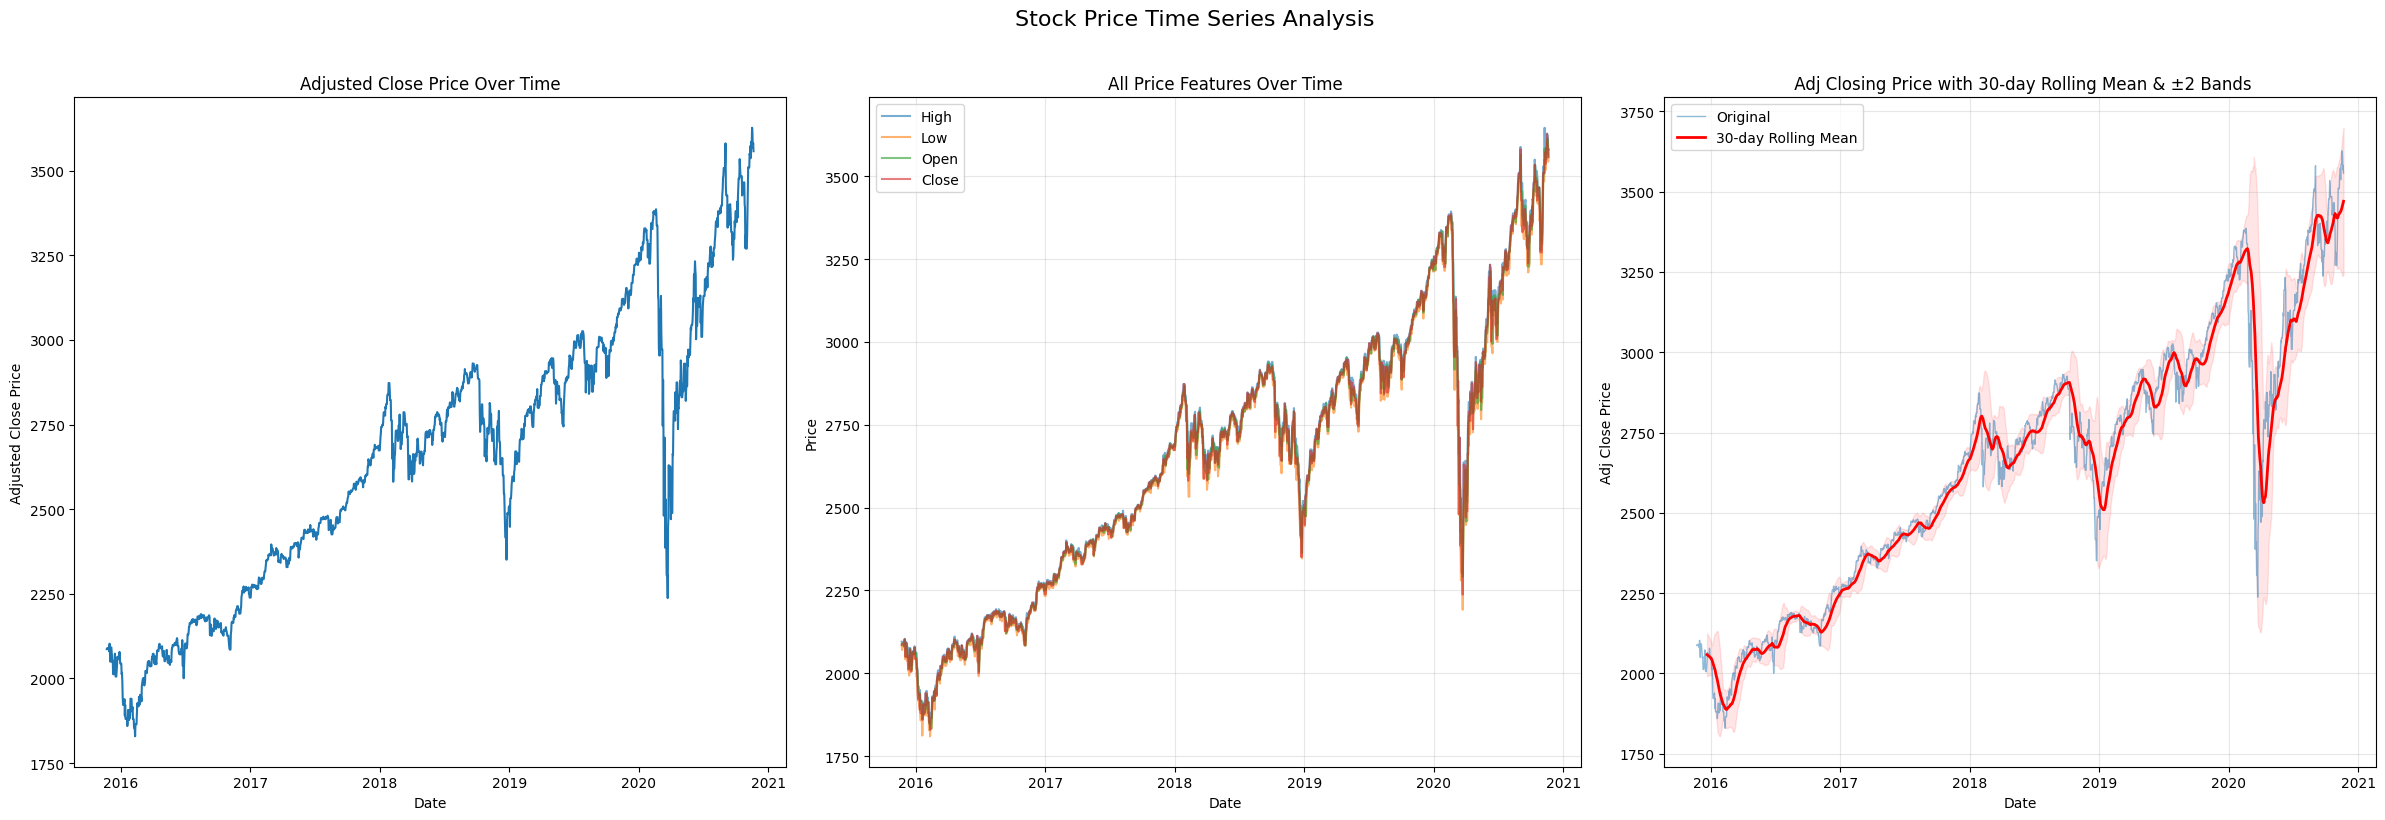

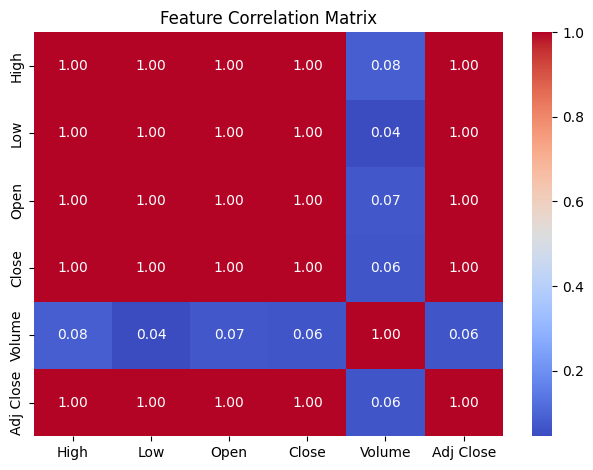

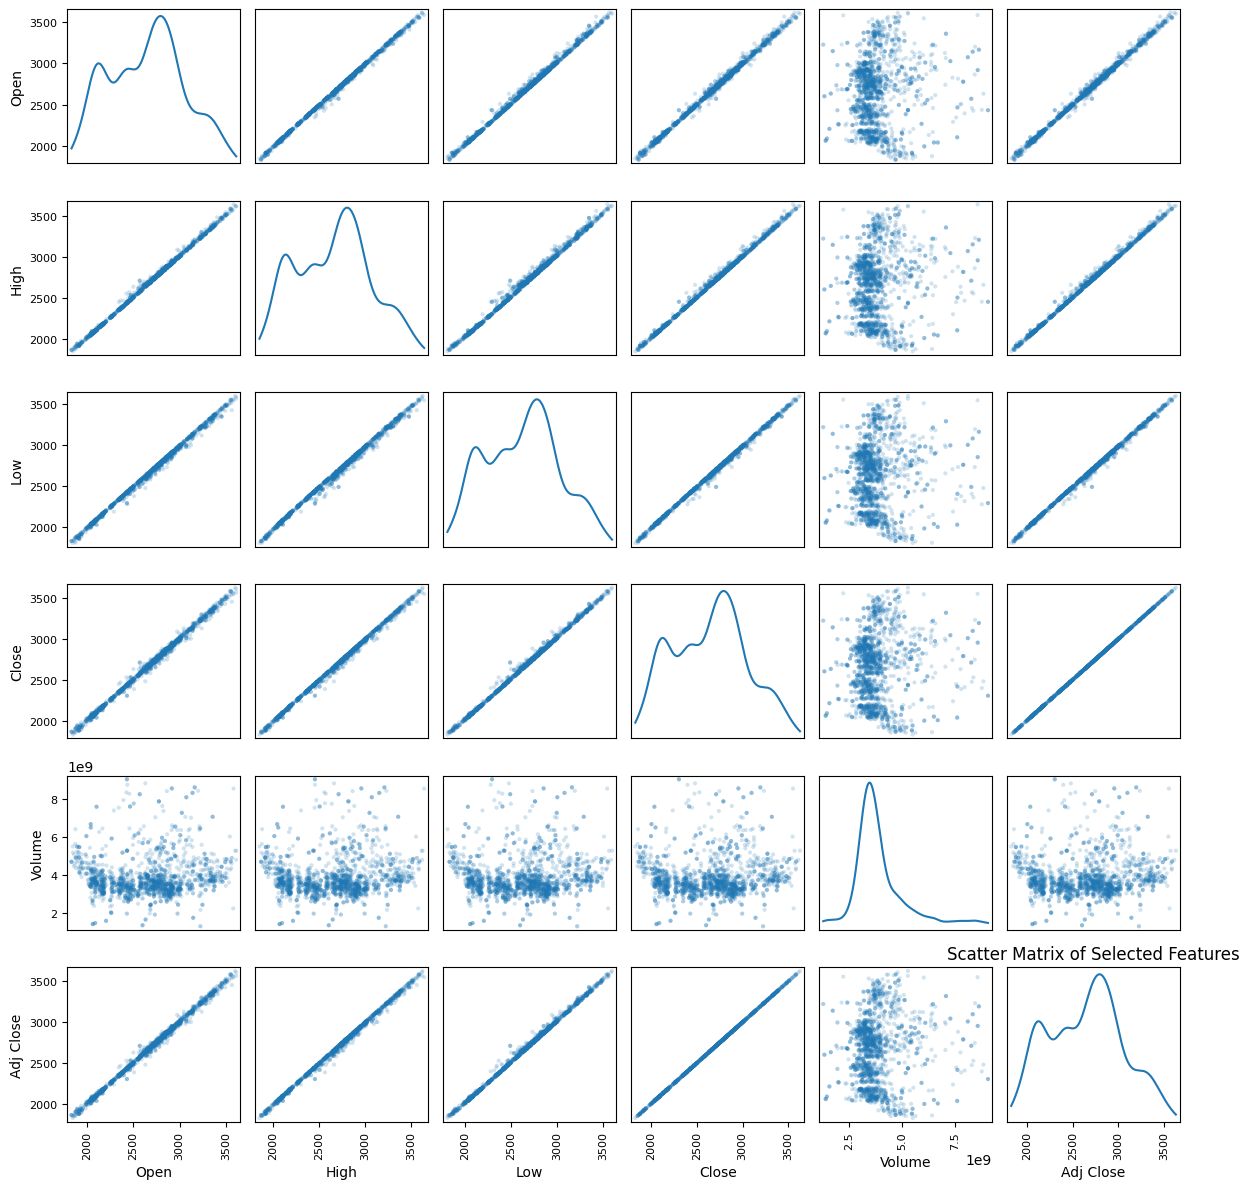

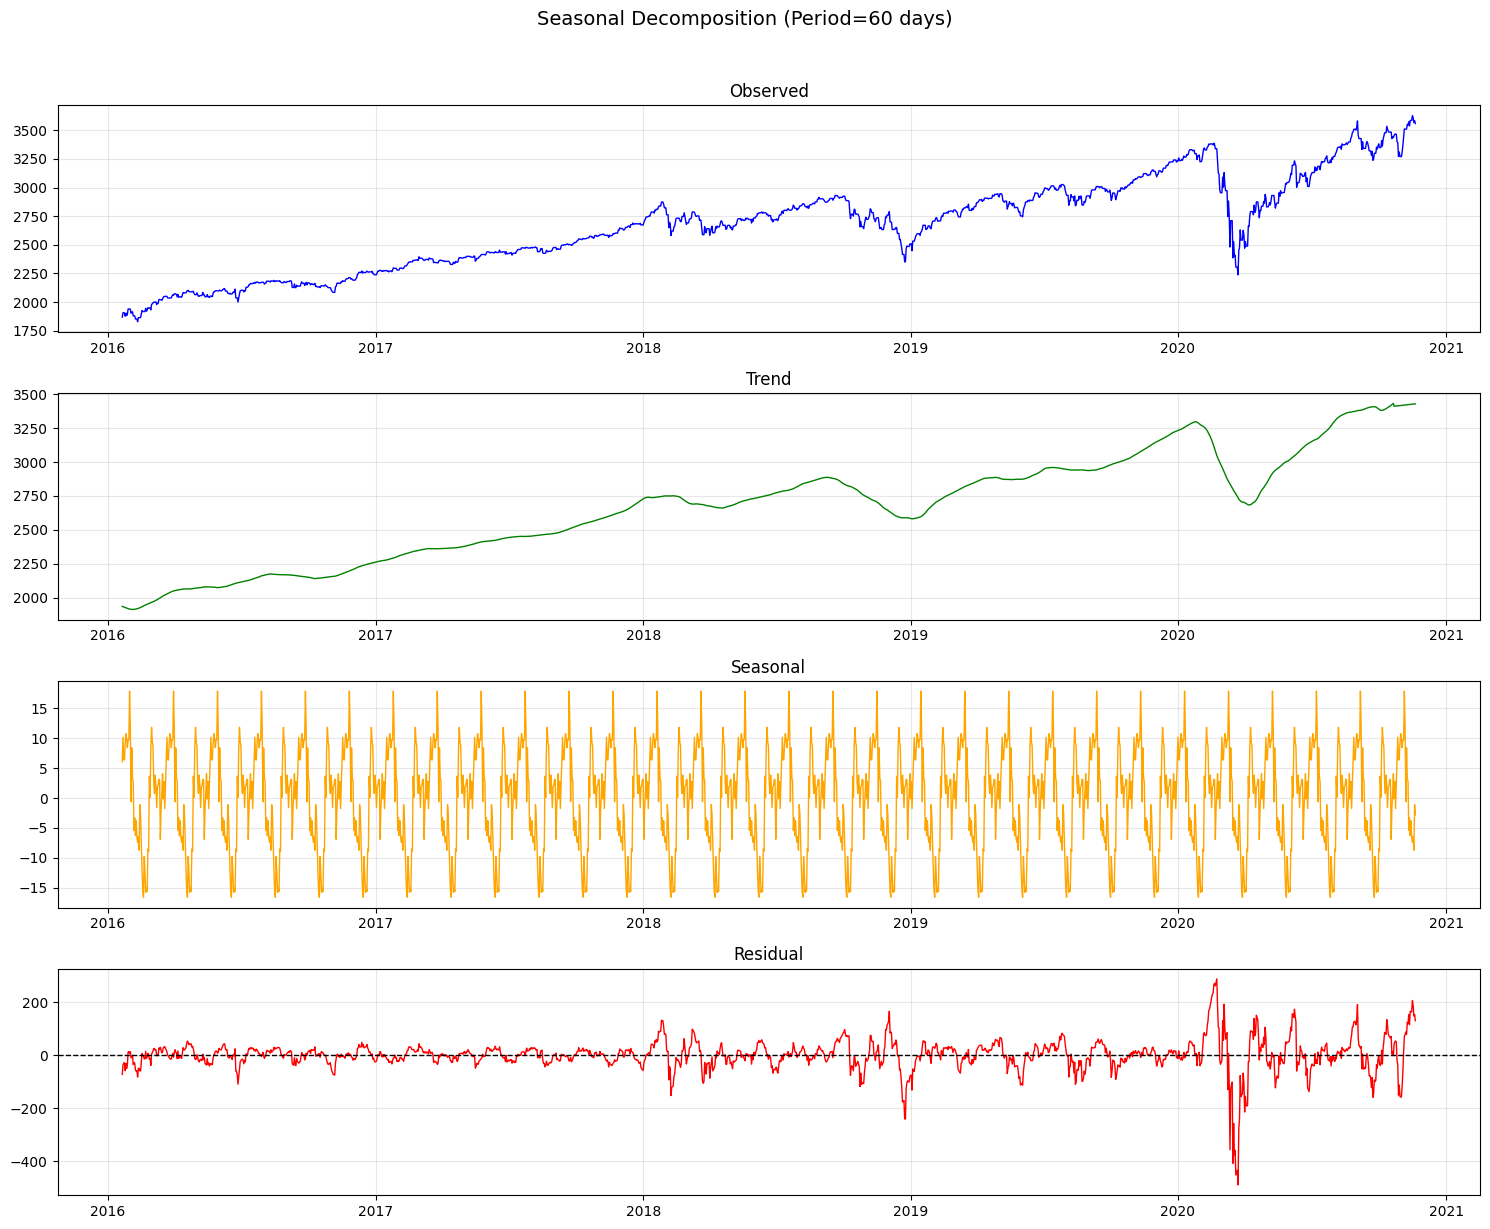

Seasonality Std Dev: 8.1797
Trend Std Dev: 398.2776
Seasonality/Trend ratio: 0.0205


In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']
explore_data(df,target_col='Adj Close',date_col='Date')

Fixed parameters across all runs:
units: 4
Dpr: 0.2
Seq: 60
target_idx: 5
batch_size: 32
learning_rate: 0.001
validation_split: 0.2
patience: 15
min_lr: 1e-05




Training data shape: (1412, 60, 6)
Testing data shape: (353, 60, 6)
Training run: 3_epochs
Epochs: 3








Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 60, 4)          │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 4)          │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469 (1.83 KB)

 Trainable params: 469 (1.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1182 - mae: 0.2869 - mse: 0.1182 - val_loss: 0.1341 - val_mae: 0.3438 - val_mse: 0.1341 - learning_rate: 0.0010
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0343 - mae: 0.1416 - mse: 0.0343 - val_loss: 0.0784 - val_mae: 0.2650 - val_mse: 0.0784 - learning_rate: 0.0010
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0176 - mae: 0.0933 - mse: 0.0176 - val_loss: 0.0347 - val_mae: 0.1749 - val_mse: 0.0347 - learning_rate: 0.0010

Metrics for 3_epochs
Mean squared error: 112078.2736
Root Mean Squared Error: 334.7809
Mean Absolute Error: 314.4010
r2 Score: -0.4610
Final Validation MSE: 0.03467562049627304
Final Validation MAE: 0.1748780906200409
Training run: 4_epochs
Epochs: 4








Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 4)          │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 4)          │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469 (1.83 KB)

 Trainable params: 469 (1.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1015 - mae: 0.2645 - mse: 0.1015 - val_loss: 0.1455 - val_mae: 0.3551 - val_mse: 0.1455 - learning_rate: 0.0010
Epoch 2/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0377 - mae: 0.1465 - mse: 0.0377 - val_loss: 0.0837 - val_mae: 0.2666 - val_mse: 0.0837 - learning_rate: 0.0010
Epoch 3/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0207 - mae: 0.1018 - mse: 0.0207 - val_loss: 0.0385 - val_mae: 0.1770 - val_mse: 0.0385 - learning_rate: 0.0010
Epoch 4/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0181 - mae: 0.0926 - mse: 0.0181 - val_loss: 0.0381 - val_mae: 0.1780 - val_mse: 0.0381 - learning_rate: 0.0010

Metrics for 4_epochs
Mean squared error: 123008.3987
Root Mean Squared Error: 350.7255
Mean Absolute Error: 319.9759
r2 Score: -0.6035
Final Validation MSE: 0.03805726394057274
Final Validation MAE: 0.17797893285751343
Training run: 5_epochs
Epochs: 5








Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 60, 4)          │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 60, 4)          │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469 (1.83 KB)

 Trainable params: 469 (1.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1196 - mae: 0.2933 - mse: 0.1196 - val_loss: 0.1837 - val_mae: 0.4036 - val_mse: 0.1837 - learning_rate: 0.0010
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0267 - mae: 0.1299 - mse: 0.0267 - val_loss: 0.0670 - val_mae: 0.2382 - val_mse: 0.0670 - learning_rate: 0.0010
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0155 - mae: 0.0961 - mse: 0.0155 - val_loss: 0.0326 - val_mae: 0.1622 - val_mse: 0.0326 - learning_rate: 0.0010
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0136 - mae: 0.0905 - mse: 0.0136 - val_loss: 0.0236 - val_mae: 0.1341 - val_mse: 0.0236 - learning_rate: 0.0010
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0134 - mae: 0.0869 - mse: 0.0134 - val_loss: 0.0234 - val_mae: 0.1372 - val_mse: 0.0234 - learning_rate: 0.0010

Metrics for 5_epochs
Mean squared error: 75727.0823
Root Mean Squared Error: 275.1855
Mean Absolute Error: 246.6594
r2 Score: 0.0129
Final 

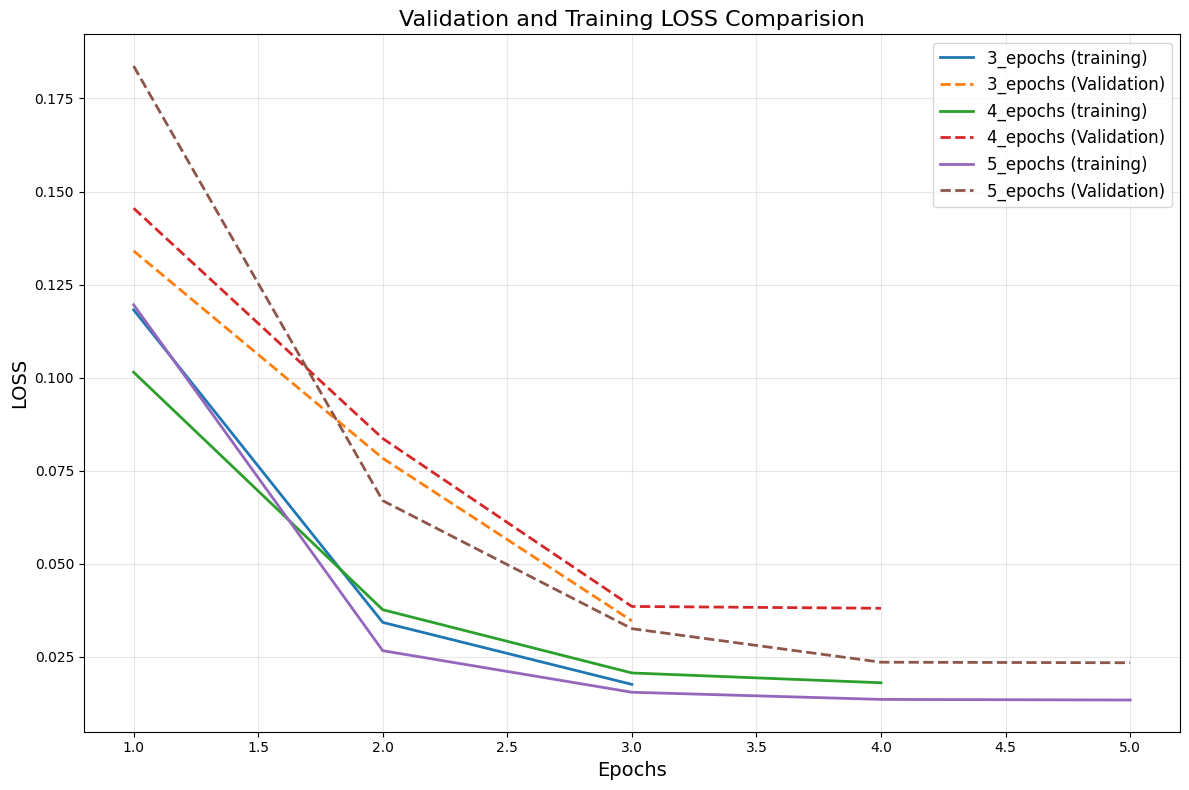

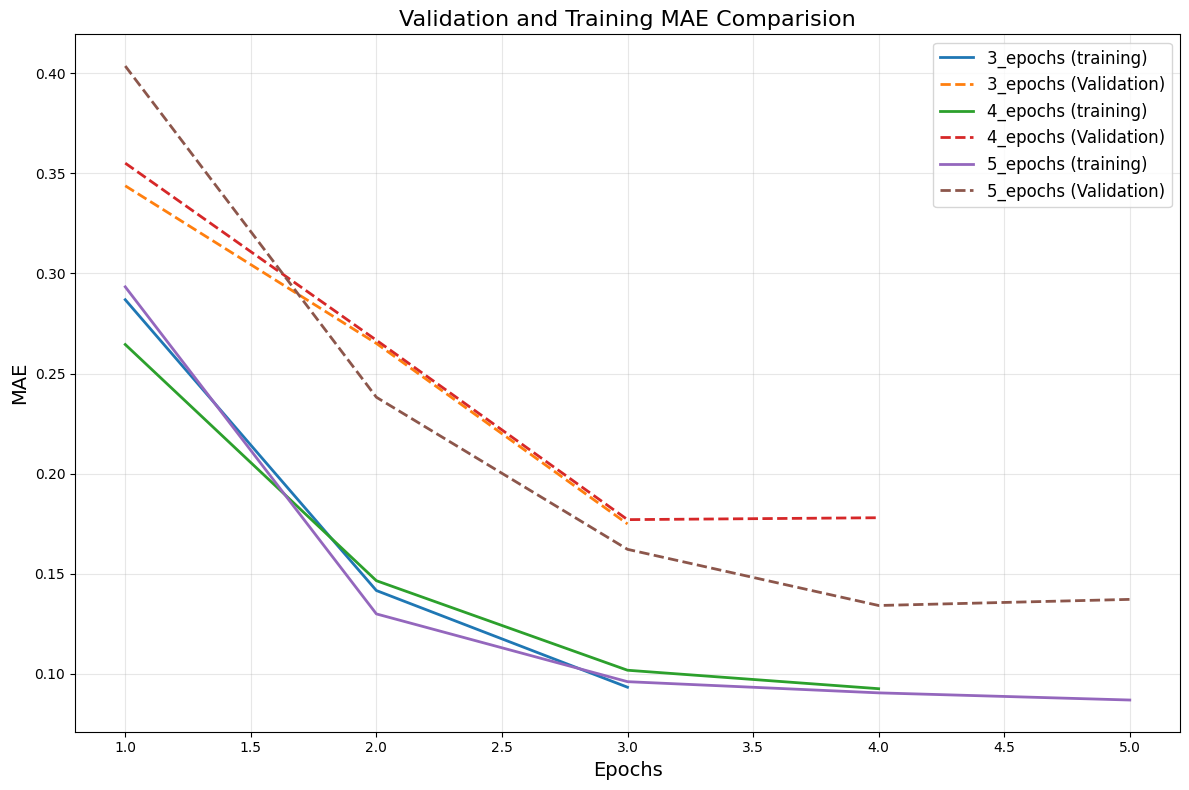


Epoch Accuracy




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



RuntimeError: Encountered an exception when converting data source to a pandas DataFrame. See traceback above for details.

<Figure size 1400x1000 with 0 Axes>

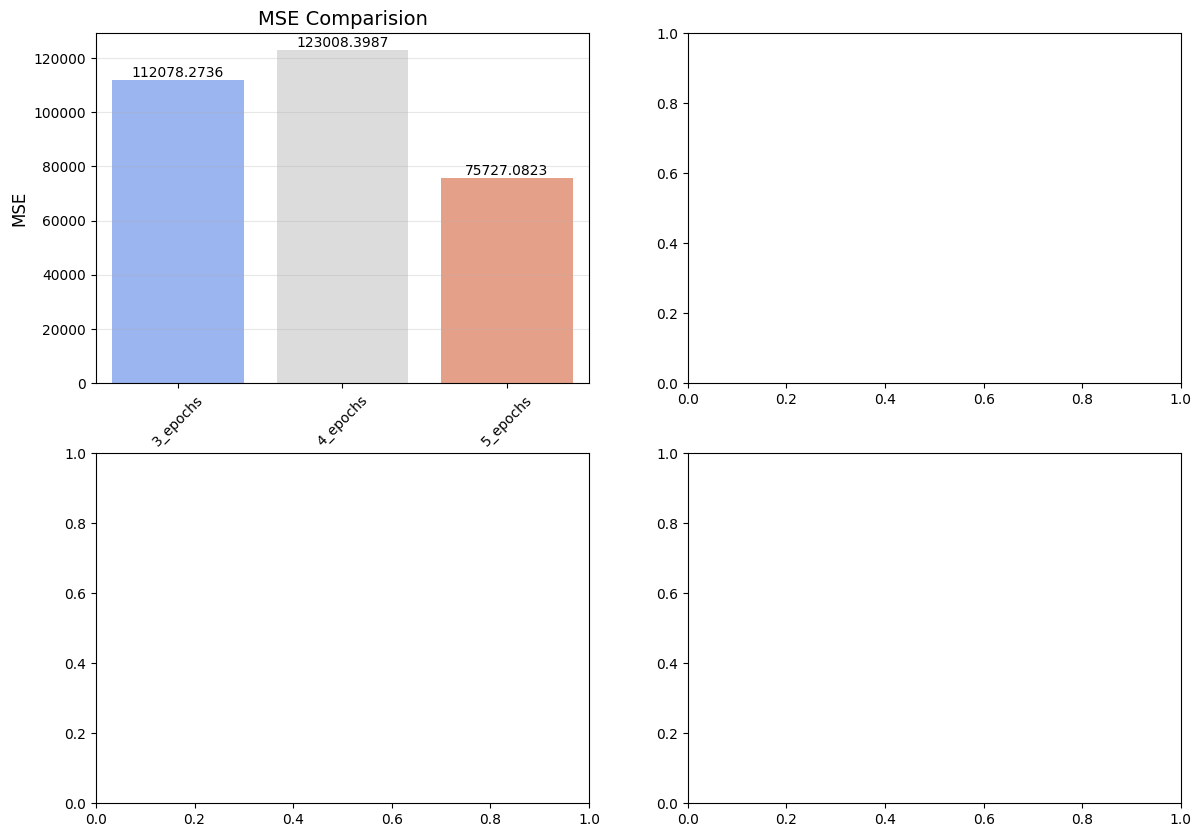

In [16]:
results_dict, results_df = hyperparameter_test(df, features)